In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 256
num_workers = 0   # 对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4
epochs = 5

In [3]:
# 首先设置数据变换
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose([
    #transforms.ToPILImage(),  
     # 这一步取决于后续的数据读取方式，如果使用内置数据集读取方式则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [4]:
## 读取方式一：使用torchvision自带数据集，下载可能需要一段时间
from torchvision import datasets

train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)
test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)

100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:05<00:00, 4519568.50it/s]


Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 2348336.04it/s]


Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:01<00:00, 3523339.27it/s]


Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw



In [5]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

torch.Size([256, 1, 28, 28]) torch.Size([256])


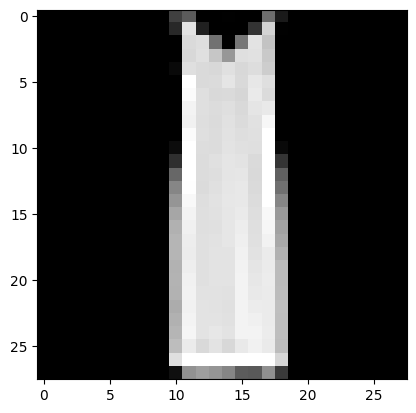

In [6]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
            
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

model = Net()
model = model.cpu()
#model = model.cuda()
# model = nn.DataParallel(model).cuda()   # 多卡训练时的写法，之后的课程中会进一步讲解

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cpu(), label.cpu()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    loss_list.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [11]:
def val(epoch):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.cpu(), label.cpu()
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

Epoch: 1 	Training Loss: 0.656020
Epoch: 1 	Validation Loss: 0.477175, Accuracy: 0.821400
Epoch: 2 	Training Loss: 0.409113
Epoch: 2 	Validation Loss: 0.348376, Accuracy: 0.875500
Epoch: 3 	Training Loss: 0.346536
Epoch: 3 	Validation Loss: 0.313639, Accuracy: 0.888000
Epoch: 4 	Training Loss: 0.320940
Epoch: 4 	Validation Loss: 0.305198, Accuracy: 0.889000
Epoch: 5 	Training Loss: 0.300233
Epoch: 5 	Validation Loss: 0.287464, Accuracy: 0.896400


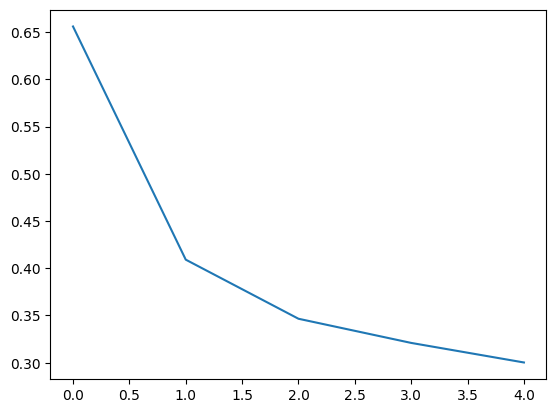

In [12]:
import matplotlib.pyplot as plt

if __name__ == "__main__": 
    loss_list = []
    for epoch in range(1, epochs+1):
        train(epoch)
        val(epoch)
    plt.figure()
    plt.plot(loss_list)
    plt.show()